# Exploratoy Analysis

This notebook contains the exploratory analysis of the zonaprop's apartments on rent data.

We will see how is the data, what are the features, and how we can use them to predict the price of an apartment.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load the data

In [43]:
data_path = '../data/data-2022-10-04-19-10-59.csv'

In [44]:
df = pd.read_csv(data_path)

In [45]:
df.head()

,url,POSTING_CARD_GALLERY,price_value,price_type,expenses_value,expenses_type,location,square_meters_area_0,square_meters_area_1,rooms_0,bedrooms_0,bathrooms_0,parking_0,description
0,/propiedades/caseros-2-amb-al-frente-con-balco...,NaN,50000,$,6500,$,"Caseros, Tres de Febrero",37,35,2,1.0,1.0,1.0,"Departamento 2 ambientes en Caseros, Tres de F..."
1,/propiedades/monoambiente-amoblado-44316362.html,NaN,40000,$,4500,$,"Caseros, Tres de Febrero",30,27,1,NaN,1.0,NaN,Departamento mono ambiente con balcon al frent...
2,/propiedades/departamento-2-ambientes.-la-merc...,NaN,43000,$,NaN,NaN,"Caseros, Tres de Febrero",35,35,2,1.0,1.0,NaN,Xintel(psp-psp-169) Departamento 2 ambientes e...
3,/propiedades/alquiler-departamento-2-ambientes...,NaN,60000,$,5000,$,"Caseros, Tres de Febrero",50,45,2,1.0,1.0,NaN,Excelente departamento 2 ambientes amplio y lu...
4,/propiedades/departamento-caseros-49382192.html,NaN,400,USD,NaN,NaN,"Caseros, Tres de Febrero",35,35,1,NaN,1.0,NaN,"Alquiler temporario, Monoambiente ubicado en C..."


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   42 non-null     object 
 1   POSTING_CARD_GALLERY  0 non-null      float64
 2   price_value           42 non-null     int64  
 3   price_type            42 non-null     object 
 4   expenses_value        24 non-null     object 
 5   expenses_type         23 non-null     object 
 6   location              42 non-null     object 
 7   square_meters_area_0  42 non-null     int64  
 8   square_meters_area_1  42 non-null     int64  
 9   rooms_0               42 non-null     int64  
 10  bedrooms_0            34 non-null     float64
 11  bathrooms_0           40 non-null     float64
 12  parking_0             6 non-null      float64
 13  description           42 non-null     object 
dtypes: float64(4), int64(4), object(6)
memory usage: 4.7+ KB


We see that the price_value column is of type object, so we need to convert it to float.

In [47]:
# Drop no casteable to float price values
import re
df = df[df.price_value.apply(lambda x: re.match(r'\d+\.?\d+', str(x)) is not None)]

In [48]:
df['price_value'] = df.price_value.astype(float)

In [49]:
print(f'Rows quantity: {len(df)}')

Rows quantity: 42


We have to clean nan data of some columns.

In [50]:
df.isna().sum()

url                      0
POSTING_CARD_GALLERY    42
price_value              0
price_type               0
expenses_value          18
expenses_type           19
location                 0
square_meters_area_0     0
square_meters_area_1     0
rooms_0                  0
bedrooms_0               8
bathrooms_0              2
parking_0               36
description              0
dtype: int64

In [51]:
df.drop(columns=['POSTING_CARD_GALLERY'], inplace=True)

In [52]:
df.dropna(subset=['square_meters_area_0', 'square_meters_area_1'], inplace=True)

There are two columns asociated to the area of the apartment, these correspond to the total area and the covered area.

We have to use the minimun value between the two columns to set the covered area and the maximum value to set the total area.

In [53]:
# Create columns with max and min area using the two columns with area values
df.loc[:, 'covered_area'] = df[['square_meters_area_0', 'square_meters_area_1']].min(axis=1)
df.loc[:, 'total_area'] = df[['square_meters_area_0', 'square_meters_area_1']].max(axis=1)

# Data Analysis

Let's see the distribution of the area of the apartments.

In [54]:
def get_df_column_by_quantile(df, column, quantile):
    return df[df[column] < df[column].quantile(quantile)][column]

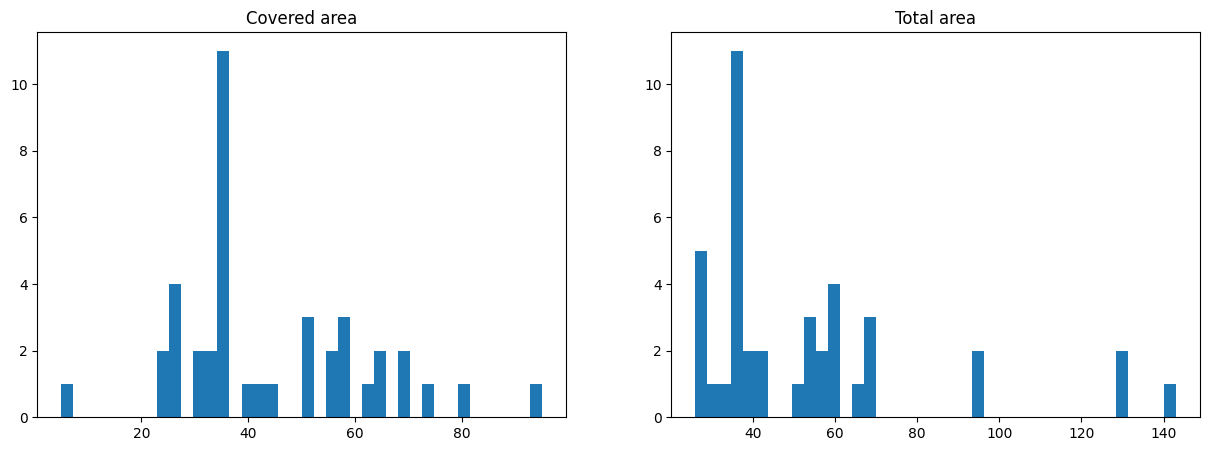

In [55]:
from matplotlib import pyplot as plt

df_data = df[(df.covered_area < df.covered_area.quantile(.99)) & (df.total_area < df.total_area.quantile(.99))]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(df_data.covered_area, bins=40)
axs[0].set_title('Covered area')

axs[1].hist(df_data.total_area, bins=40)
axs[1].set_title('Total area')

plt.show()

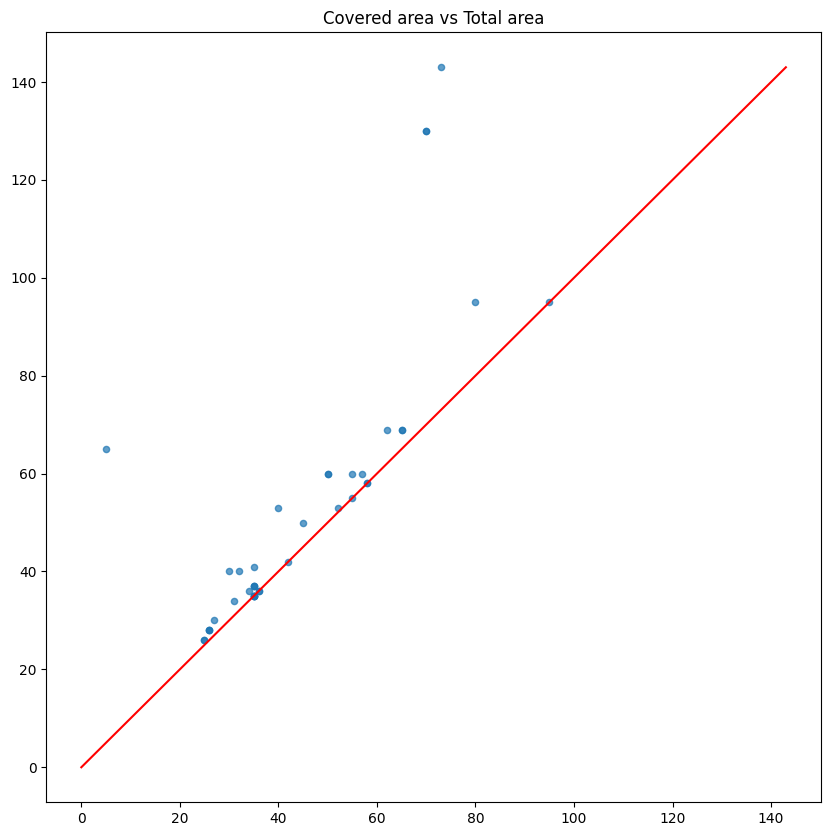

In [56]:
plt.figure(figsize=(10, 10))
plt.scatter(df_data.covered_area, df_data.total_area, alpha=0.7, s=20)

max_total_area = df_data.total_area.max()

plt.plot([0, max_total_area], [0, max_total_area], color='red')
plt.title('Covered area vs Total area')
plt.show()

Now we can see the distribution of the price of the apartment in function of the area.

We will analyze only the apartments with price_type = $. (The price is in argentinian pesos)

In [57]:
df.price_type.unique()

array(['$', 'USD'], dtype=object)

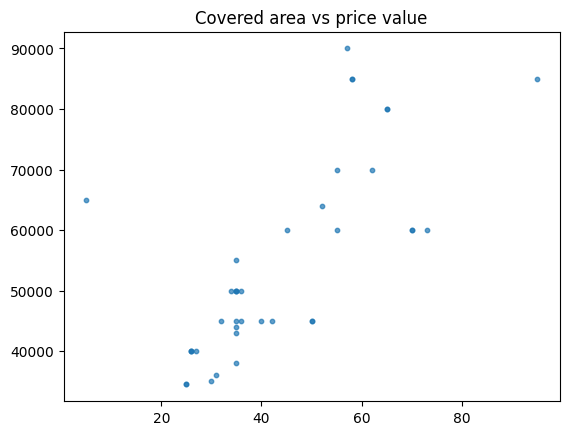

In [58]:
df_pesos = df[df['price_type'] == '$']

df_pesos_data = df_pesos[
    (df_pesos.covered_area < df_pesos.covered_area.quantile(.99))
    & (df_pesos.total_area < df_pesos.total_area.quantile(.99))
]

fig, ax = plt.subplots()

ax.scatter(df_pesos_data['covered_area'], df_pesos_data['price_value'], alpha=0.7, s=10)
ax.set_title('Covered area vs price value')

plt.show()


Let's see the distribution of the price of the apartment in function of the rooms.

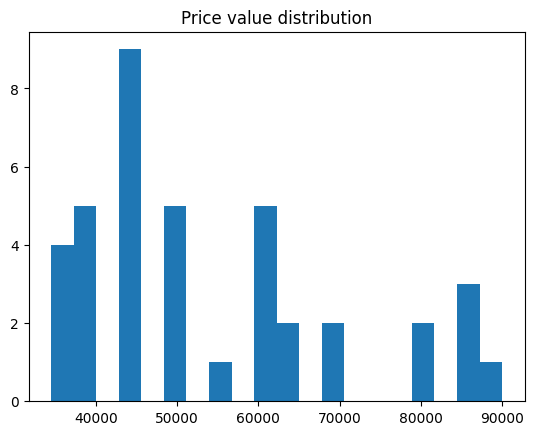

In [59]:
plt.hist(df_pesos_data['price_value'], bins=20)
plt.title('Price value distribution')
plt.show()

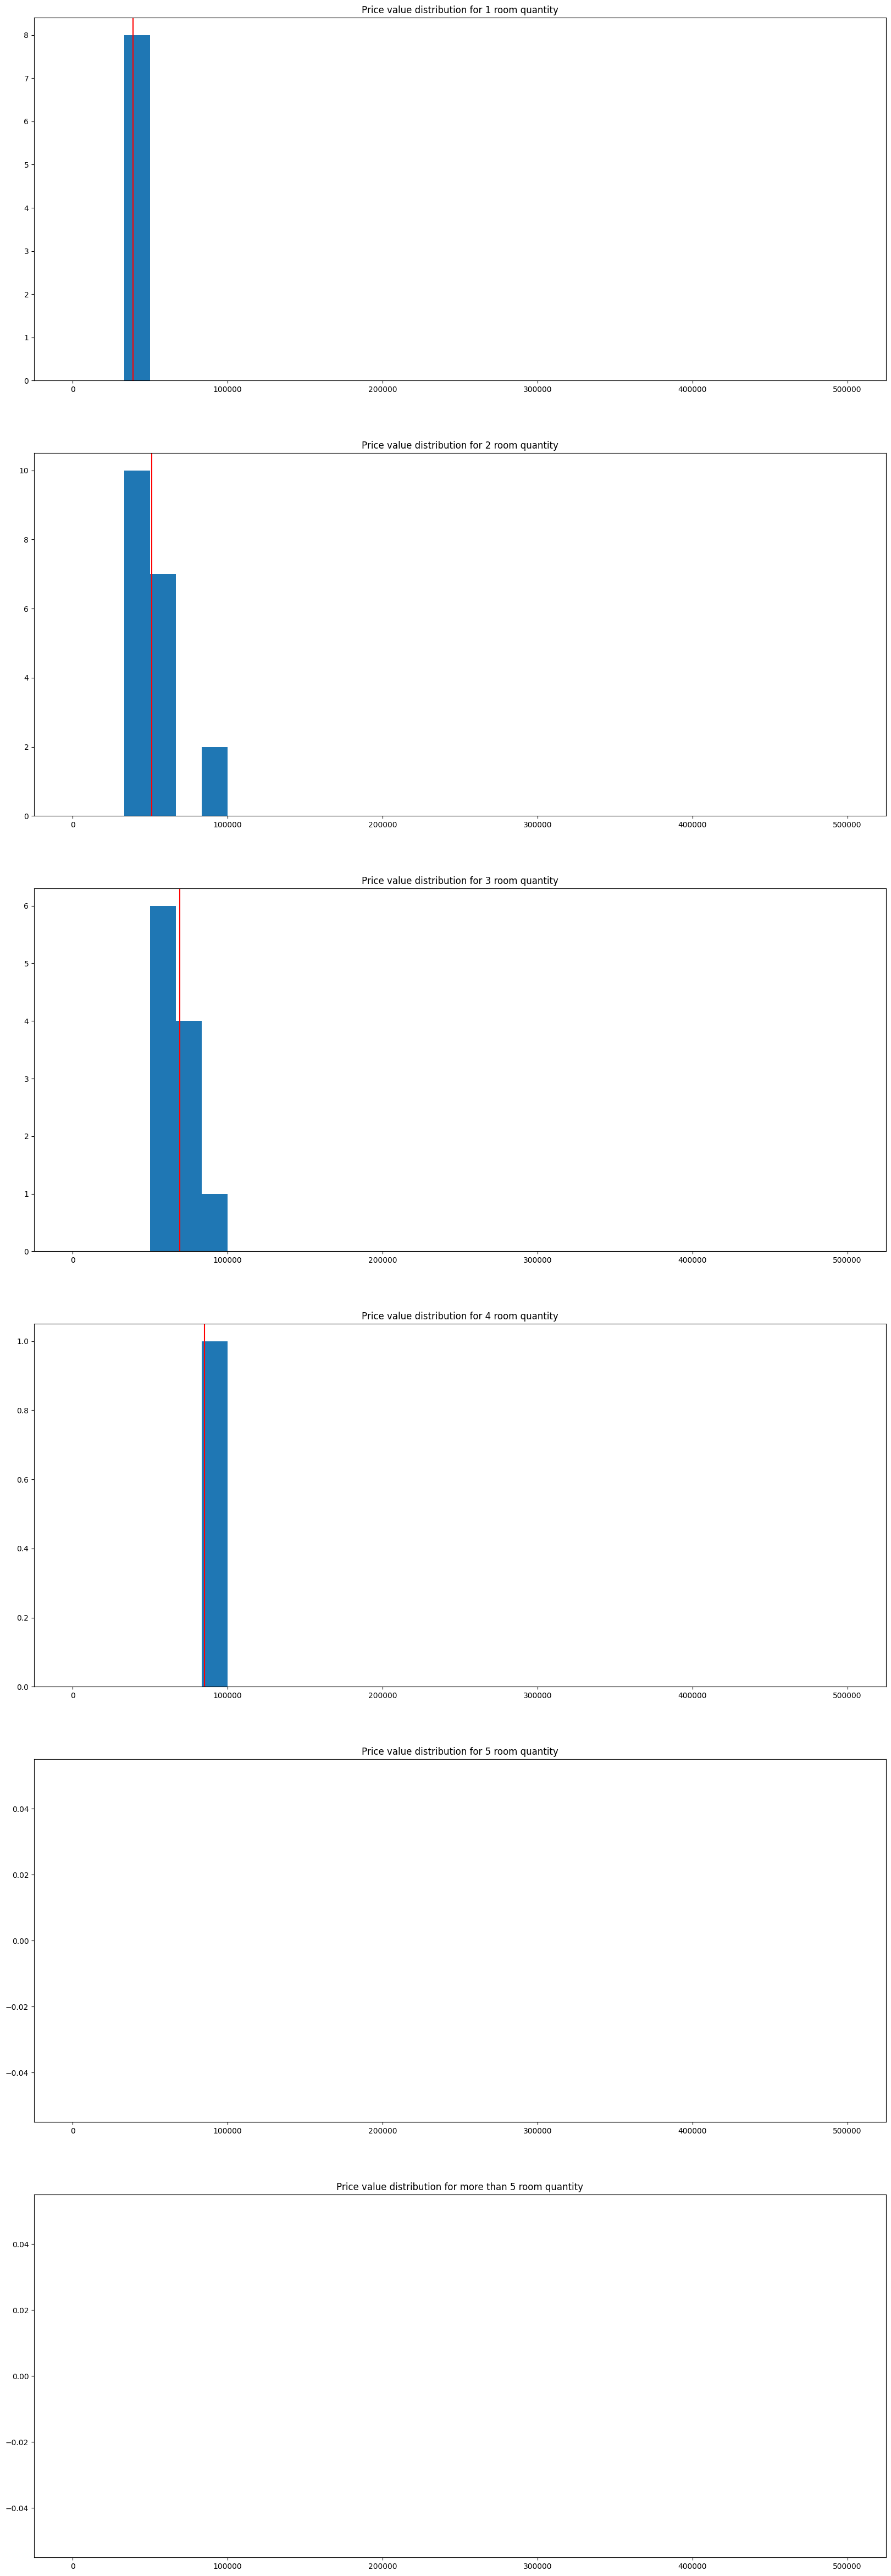

In [60]:
# create a histogram of the distribution of the price value for each room quantity sorted

df_data = df_pesos_data[df_pesos_data['rooms_0'] < 30]


# plot from 1 to 5 rooms and the rest in the same plot
# use the same axis for all plots
# draw a vertical line at the mean

fig, axs = plt.subplots(6, 1, figsize=(20, 60))

rest_of_room_quantity_df = df_data[df_data['rooms_0'] > 5]

for i in range(1, 6):

    room_quantity_df = df_data[df_data['rooms_0'] == i]

    axs[i-1].hist(room_quantity_df['price_value'], bins=30, range=(0, 500000))
    axs[i-1].set_title(f'Price value distribution for {i} room quantity')
    axs[i-1].axvline(room_quantity_df['price_value'].mean(), color='red')

axs[5].hist(rest_of_room_quantity_df['price_value'], bins=30, range=(0, 500000))
axs[5].set_title(f'Price value distribution for more than 5 room quantity')
axs[5].axvline(rest_of_room_quantity_df['price_value'].mean(), color='red')

plt.show()


We can see that the price value mean increases with the number of rooms until 4 rooms, and then it doesn't increase anymore and it even decreases.

In [61]:
df_pesos_data.describe()

,price_value,square_meters_area_0,square_meters_area_1,rooms_0,bedrooms_0,bathrooms_0,parking_0,covered_area,total_area
count,39.000000,39.000000,39.000000,39.000000,32.000000,38.0,5.0,39.000000,39.000000
mean,54333.333333,52.794872,43.615385,2.128205,1.375000,1.0,1.0,43.615385,52.794872
std,16054.321165,28.399573,17.654007,0.767068,0.553581,0.0,0.0,17.654007,28.399573
min,34500.000000,26.000000,5.000000,1.000000,1.000000,1.0,1.0,5.000000,26.000000
25%,43500.000000,35.000000,33.000000,2.000000,1.000000,1.0,1.0,33.000000,35.000000
50%,50000.000000,41.000000,36.000000,2.000000,1.000000,1.0,1.0,36.000000,41.000000
75%,62000.000000,60.000000,56.000000,3.000000,2.000000,1.0,1.0,56.000000,60.000000
max,90000.000000,143.000000,95.000000,4.000000,3.000000,1.0,1.0,95.000000,143.000000
